# Downloading DESI Spectra
A notebook to demonstrate methods for dowloading both co-added and individual DESI spectra.

In [1]:
import io
import sys
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.visualization import PercentileInterval
from matplotlib.gridspec import GridSpec

sys.path.insert(1, '../')
import desi_tools as desi
from plot_tools import lighten_color

# Open the DESI zpix file
The file being loaded here is just a subset of the zall_pix_fuji.fits file that was cross-matched with the Gentile Fusillo White Dwarf Catalog.

In [2]:
zpix_name = "../data/zpix_wds.csv"
zpix = pd.read_csv(zpix_name)

Ntarg = len(zpix)
Nuniq = len(zpix['TARGETID'].unique())

print(f"{Ntarg} Entries")
print(f"{Nuniq} Unique Target IDs\n")
zpix.head(3)

5005 Entries
3756 Unique Target IDs



,TARGETID,SURVEY,PROGRAM,HEALPIX,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF,...,e_rmag,imag,e_imag,zmag,e_zmag,SDSS_separation,SDSS_spec,GroupID,GroupSize,Separation
0,39628478462559007,cmx,other,2153,2153,0.000225,3.203308e-05,0,8.810969e+03,"(1422.2779935269818, 525.627452782257, 65.2956...",...,0.020,19.717,0.031,20.006,0.163,0.028466,NaN,NaN,NaN,0.299466
1,39628483684466824,cmx,other,2154,2154,0.000212,2.459236e-05,0,1.122528e+04,"(2642.1652455910025, 407.29971914395895, 152.6...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.062984
2,39628483684466993,cmx,other,2154,2154,-0.001996,4.131149e-48,1570,9.000000e+99,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,0.023,19.639,0.030,19.861,0.134,0.064205,NaN,NaN,NaN,0.184200


# Use desi_tools to get the Co-added Spectrum
Using "get_DESI_spectrum" in desi_tools will be quite slow, since it will download a healpix coadd file that contains spectra for hundreds of objects, and then extract the one row corresponding to your target. You can also tell this function to print out a URL where you can just look at the spectrum.

In [3]:
# Define the target ID
obj_ID = 39627775694340540

# Get target info from zpix file
zidx = zpix.TARGETID == obj_ID
obj_surveys = zpix.SURVEY[zidx].values
obj_programs = zpix.PROGRAM[zidx].values
obj_healpixels = zpix.HEALPIX[zidx].values
obj_svprimes = zpix.SV_PRIMARY[zidx].values
obj_numexp = zpix.COADD_NUMEXP[zidx].values
obj_pixnums = [int(x/100) for x in obj_healpixels]
num_entries = len(obj_surveys)

# Print out summary of DESI observation of target
print(f"Target ID {obj_ID} Observed in:")
print(f"----------------------------------------")
for i in range(num_entries):
    print(
        f"{i+1}) Survey = {obj_surveys[i]},  " +\
        f"Program = {obj_programs[i]:6s},  " +\
        f"Primary = {str(obj_svprimes[i]):5s},  " +\
        f"Nexp = {obj_numexp[i]}"
    )
pidx = np.where(obj_svprimes)[0][0]
sidx = pidx # Choose index of spectrum you want

# Download the coadd
specdata = desi.get_DESI_spectrum(
    obj_ID,
    obj_surveys[sidx],
    obj_programs[sidx],
    obj_healpixels[sidx],
    download_spectrum=True,
    coadd=True,
    show_viz_url=True
)

Target ID 39627775694340540 Observed in:
----------------------------------------
1) Survey = sv1,  Program = bright,  Primary = False,  Nexp = 11
2) Survey = sv1,  Program = dark  ,  Primary = True ,  Nexp = 9
3) Survey = sv3,  Program = bright,  Primary = False,  Nexp = 1
4) Survey = sv3,  Program = dark  ,  Primary = False,  Nexp = 1

DESI Spectrum Viewer: https://www.legacysurvey.org/viewer/desi-spectrum/edr/targetid39627775694340540

Retrieving DESI spectrum...Finished
Response time: 6.4 seconds
Response status code: 200 SUCCESS
Response size: 219 Mb


# Now use [SPARCL](https://astrosparcl.datalab.noirlab.edu/) to get the Co-added Spectrum
SPARCL is a python client, providing an API for downloading **co-added** DESI spectra. It is much faster for downloading single-object spectra, but does not provide access to the individual spectra used to create the coadds, although it does now provide each coadd for objects observed in multiple DESI surveys/programs. Initially, SPARCL only provided access to the coadd labeled with SV_PRIMARY = True in the zall_pix_fuji table. SPARCL also provides an additional advantage that the spectra from each spectrograph arm have been combined into a single spectrum, whereas those you get directly from the DESI archive (via the "get_DESI_spectrum" function) are still split up by spectrograph arm, of which there are three.

In [4]:
from sparcl.client import SparclClient

# Set up the client
client = SparclClient()
target_ids = [int(obj_ID)]
include_cols = ['specid', 'sv_primary', 'flux', 'wavelength']

# Send the query
print('Retrieving DESI spectrum using SPARCL...',end='')
t0 = time.time()
sparcl_result = client.retrieve_by_specid(
    specid_list=target_ids, 
    include=include_cols, 
    dataset_list=['DESI-EDR']
)
t1 = time.time()
print('Finished')
print(f'Response time: {t1-t0:.1f} seconds')

# Get the record for your object
sparcl_svprimary_idx = [x['sv_primary'] for x in sparcl_result.records].index(True)
record = sparcl_result.records[sparcl_svprimary_idx]

Retrieving DESI spectrum using SPARCL...Finished
Response time: 0.5 seconds


# Plot the Co-added Spectrum, Comparing the SPARCL and get_DESI_spectrum results

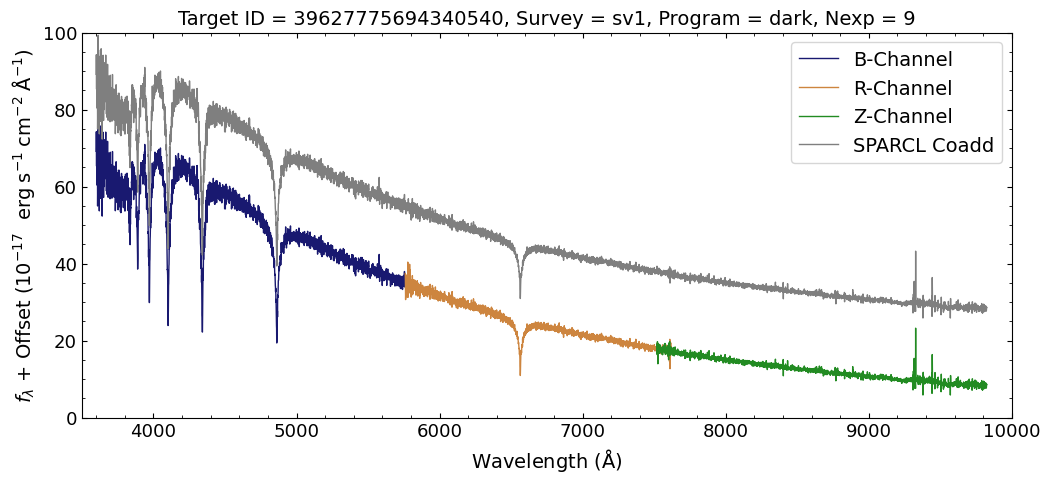

In [5]:
# Plot the Spectra
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)

# Plot spectrum from "get_DESI_spectrum"
ax.plot(
    specdata['b_wave'], specdata['spec_1']['b_flux'], 
    lw=1, zorder=0, label="B-Channel", c="midnightblue")
ax.plot(
    specdata['r_wave'], specdata['spec_1']['r_flux'], 
    lw=1, zorder=1, label="R-Channel", c="peru")
ax.plot(
    specdata['z_wave'], specdata['spec_1']['z_flux'], 
    lw=1, zorder=2, label="Z-Channel", c="forestgreen")

# Plot Spectrum from SPARCL
ax.plot(
    record['wavelength'], record['flux']+20, 
    lw=1, zorder=2, label="SPARCL Coadd", c="C7"
)

# Make a plot title
title = "Target ID = {}, Survey = {}, Program = {}, Nexp = {}".format(
    obj_ID, obj_surveys[sidx], obj_programs[sidx], obj_numexp[sidx])
ax.set_title(title,fontsize=14)

# Set appearances
ax.set_xlim(3500,10000)
ax.set_ylim(0, 100)
ax.set_xlabel('Wavelength ($\mathrm{\AA}$)',fontsize=14)
ax.set_ylabel('$f_{\lambda}$ $+$ Offset (10$^{-17}$  $\mathrm{erg\;s^{-1}\;cm^{-2}\;\AA^{-1}}$)',fontsize=14)
ax.minorticks_on()
ax.tick_params(which='both',top=True,right=True,direction='in',labelsize=13)
ax.legend(loc='upper right',fontsize=14);

# Get Individual DESI Spectra for an Object
SPARCL is much faster for retrieveing single-object spectra, but only provides access to the **coadded** spectra. If you want to look at the individual spectra that comprise the coadded spectrum, you can again use the "get_DESI_spectrum" function in desi_tools, but this time setting the "coadd" parameter to False.

In [6]:
specdata = desi.get_DESI_spectrum(
    obj_ID,
    obj_surveys[sidx],
    obj_programs[sidx],
    obj_healpixels[sidx],
    download_spectrum=True,
    coadd=False,
    show_viz_url=False
)
Nspec = sum(['spec' in k for k in specdata.keys()])


Retrieving DESI spectrum...Finished
Response time: 31.1 seconds
Response status code: 200 SUCCESS
Response size: 1828 Mb


/home/zachvanderbosch/github/StellarTools/Spectroscopy/DESI/notebooks/../desi_tools.py:209: RuntimeWarning: divide by zero encountered in divide
  'r_eflux':np.sqrt(1./rivar),
/home/zachvanderbosch/github/StellarTools/Spectroscopy/DESI/notebooks/../desi_tools.py:211: RuntimeWarning: divide by zero encountered in divide
  'z_eflux':np.sqrt(1./zivar)
/home/zachvanderbosch/github/StellarTools/Spectroscopy/DESI/notebooks/../desi_tools.py:207: RuntimeWarning: divide by zero encountered in divide
  'b_eflux':np.sqrt(1./bivar),


# Plot the Individual Spectra

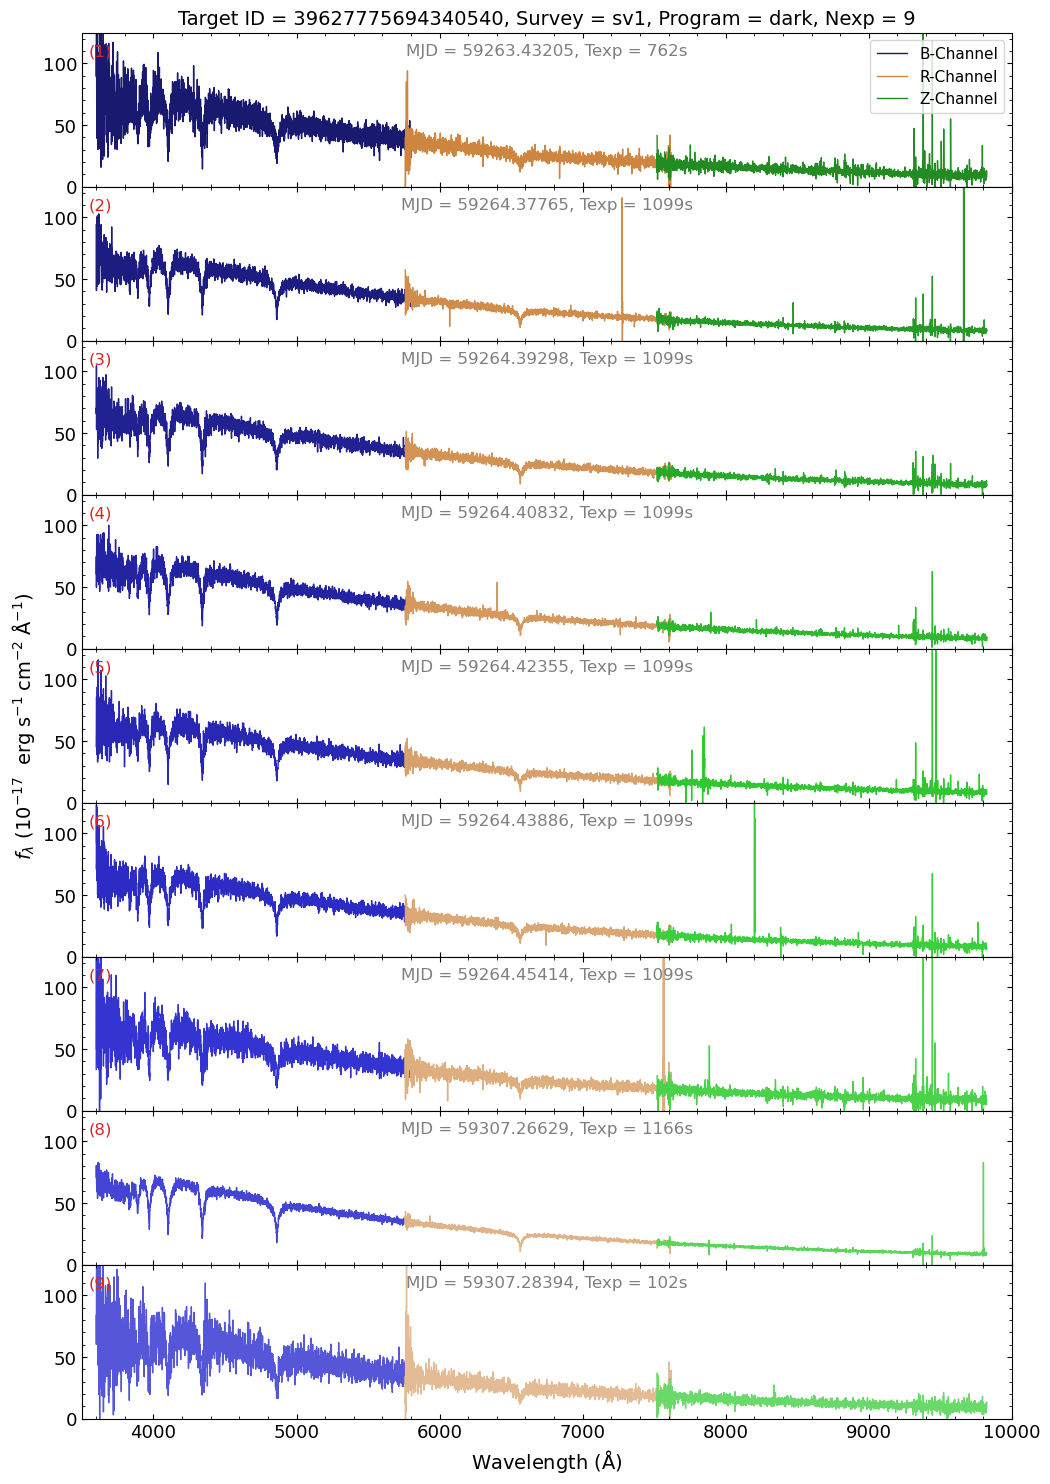

In [7]:
# Plot the Spectra
fig = plt.figure(figsize=(12,2*Nspec))
gs = GridSpec(Nspec,1,hspace=0)

yupp = 0.0
ylow = 0.0
flux_range = 0.0
for i in range(Nspec):

    ax = fig.add_subplot(gs[i])

    # Get key and define color shading
    spec_key = f"spec_{i+1:d}"
    lighten_step = 0.5/Nspec
    lamount = 1.0-i*lighten_step
    
    ax.plot(
        specdata['b_wave'], specdata[spec_key]['b_flux'], 
        lw=1, zorder=0, label="B-Channel",
        c=lighten_color("midnightblue",amount=lamount)
    )
    ax.plot(
        specdata['r_wave'], specdata[spec_key]['r_flux'], 
        lw=1, zorder=1, label="R-Channel",
        c=lighten_color("peru",amount=lamount)
    )
    ax.plot(
        specdata['z_wave'], specdata[spec_key]['z_flux'], 
        lw=1, zorder=2, label="Z-Channel",
        c=lighten_color("forestgreen",amount=lamount)
    )
    ax.text(0.02,0.85,f'({i+1})',
            transform=ax.transAxes,ha='center',color='C3',fontsize=12)
    ax.text(0.5,0.85,'MJD = {:.5f}, Texp = {:.0f}s'.format(
        specdata[spec_key]['mjd'],specdata[spec_key]['exptime']),
        transform=ax.transAxes,ha='center',color='C7',fontsize=12)

    # Make a plot title
    if i == 0:
        title = "Target ID = {}, Survey = {}, Program = {}, Nexp = {}".format(
            obj_ID, obj_surveys[sidx], obj_programs[sidx], obj_numexp[sidx])
        ax.set_title(title,fontsize=14)
        ax.legend(loc='upper right',fontsize=11)

    # Set appearances
    ax.set_xlim(3500,10000)
    ax.set_ylim(0,125)
    ax.minorticks_on()
    if i < Nspec-1:
        ax.tick_params(which='both',top=True,right=True,direction='in',labelbottom=False,labelsize=13)
    else:
        ax.set_xlabel('Wavelength ($\mathrm{\AA}$)',fontsize=14)
        ax.tick_params(which='both',top=True,right=True,direction='in',labelbottom=True,labelsize=13)
    if i == int(Nspec/2):
        ax.set_ylabel('$f_{\lambda}$ (10$^{-17}$  $\mathrm{erg\;s^{-1}\;cm^{-2}\;\AA^{-1}}$)',fontsize=14)

# Getting **ALL** Spectra for a Given Object
The plot above only shows the 9 individual spectra that were contained within the **PRIMARY** coadd for this object. This object, however, was actually observed in four different Survey + Program combinations, as shown below, with a total 22 exposures:

Target ID 39627775694340540 Observed in:
----------------------------------------
1) Survey = sv1,  Program = bright,  Primary = False,  Nexp = 11
2) Survey = sv1,  Program = dark  ,  Primary = True ,  Nexp = 9
3) Survey = sv3,  Program = bright,  Primary = False,  Nexp = 1
4) Survey = sv3,  Program = dark  ,  Primary = False,  Nexp = 1

If you want every spectrum available for a target, you will have to loop over these different combinations, as shown below.

In [8]:
all_specdata = []
all_Nspec = 0
for sur,pro,pix in zip(obj_surveys, obj_programs, obj_healpixels):

    sdata = desi.get_DESI_spectrum(
        obj_ID,
        sur,
        pro,
        pix,
        download_spectrum=True,
        coadd=False,
        show_viz_url=False
    )
    all_Nspec += sum(['spec' in k for k in sdata.keys()])
    all_specdata.append(sdata)


Retrieving DESI spectrum...Finished
Response time: 29.1 seconds
Response status code: 200 SUCCESS
Response size: 1663 Mb

Retrieving DESI spectrum...Finished
Response time: 44.7 seconds
Response status code: 200 SUCCESS
Response size: 1828 Mb

Retrieving DESI spectrum...Finished
Response time: 26.2 seconds
Response status code: 200 SUCCESS
Response size: 1289 Mb

Retrieving DESI spectrum...Finished
Response time: 32.5 seconds
Response status code: 200 SUCCESS
Response size: 1841 Mb


# Plot ALL Spectra

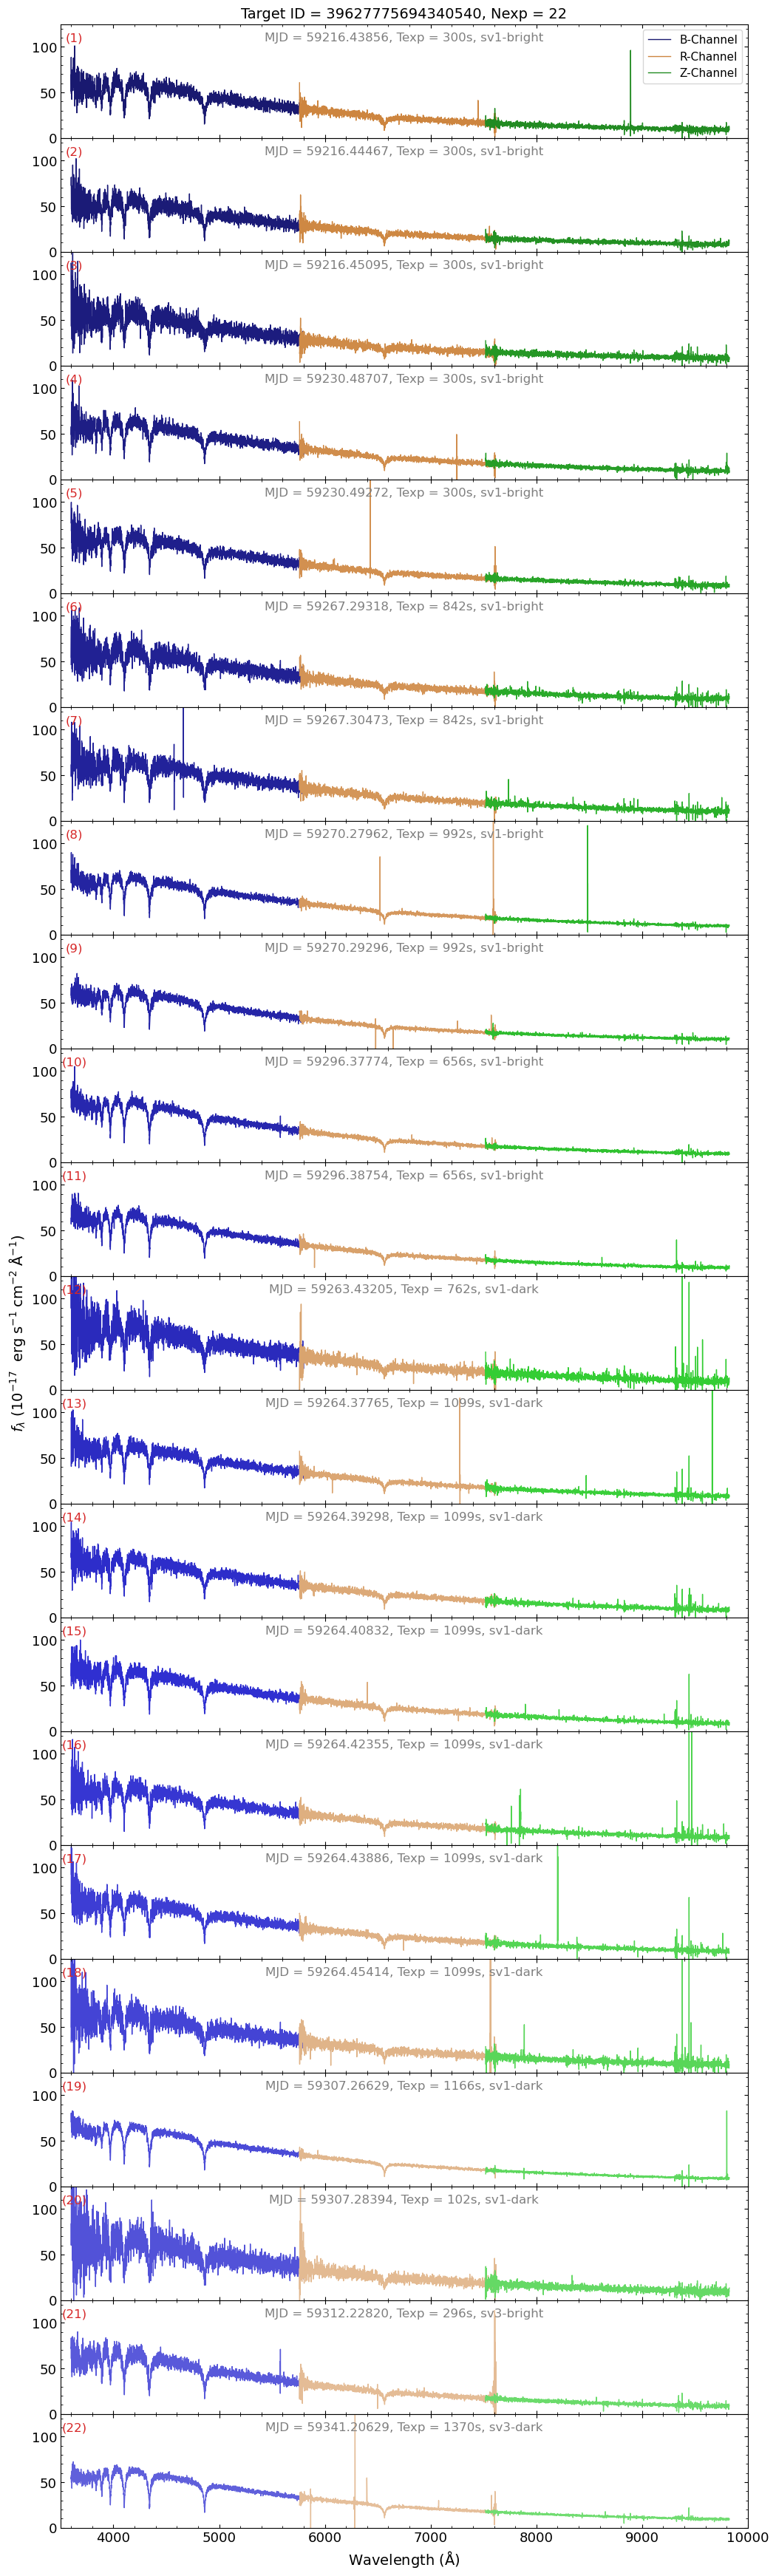

In [9]:
fig = plt.figure(figsize=(12,2*all_Nspec))
gs = GridSpec(all_Nspec,1,hspace=0)

pcount = 0
for sn,spec_entry in enumerate(all_specdata):

    Nspec_entry = sum([1 for k in spec_entry.keys() if 'spec' in k])

    for i in range(Nspec_entry):
    
        ax = fig.add_subplot(gs[pcount])
    
        # Get key and define color shading
        spec_key = f"spec_{i+1:d}"
        lighten_step = 0.5/all_Nspec
        lamount = 1.0-pcount*lighten_step
        
        ax.plot(
            spec_entry['b_wave'], spec_entry[spec_key]['b_flux'], 
            lw=1, zorder=0, label="B-Channel",
            c=lighten_color("midnightblue",amount=lamount)
        )
        ax.plot(
            spec_entry['r_wave'], spec_entry[spec_key]['r_flux'], 
            lw=1, zorder=1, label="R-Channel",
            c=lighten_color("peru",amount=lamount)
        )
        ax.plot(
            spec_entry['z_wave'], spec_entry[spec_key]['z_flux'], 
            lw=1, zorder=2, label="Z-Channel",
            c=lighten_color("forestgreen",amount=lamount)
        )
        ax.text(0.02,0.85,f'({pcount+1})',
            transform=ax.transAxes,ha='center',color='C3',fontsize=12)
        ax.text(0.5,0.85,'MJD = {:.5f}, Texp = {:.0f}s, {}-{}'.format(
            spec_entry[spec_key]['mjd'],spec_entry[spec_key]['exptime'],
            obj_surveys[sn],obj_programs[sn]),
            transform=ax.transAxes,ha='center',color='C7',fontsize=12)
    
        # Make a plot title
        if pcount == 0:
            title = "Target ID = {}, Nexp = {}".format(
                obj_ID, all_Nspec)
            ax.set_title(title,fontsize=14)
            ax.legend(loc='upper right',fontsize=11)
    
        # Set appearances
        ax.set_xlim(3500,10000)
        ax.set_ylim(0,125)
        ax.minorticks_on()
        if pcount < all_Nspec-1:
            ax.tick_params(which='both',top=True,right=True,direction='in',labelbottom=False,labelsize=13)
        else:
            ax.set_xlabel('Wavelength ($\mathrm{\AA}$)',fontsize=14)
            ax.tick_params(which='both',top=True,right=True,direction='in',labelbottom=True,labelsize=13)
        if pcount == int(all_Nspec/2):
            ax.set_ylabel('$f_{\lambda}$ (10$^{-17}$  $\mathrm{erg\;s^{-1}\;cm^{-2}\;\AA^{-1}}$)',fontsize=14)
        pcount += 1